### Predicting the stock prices of Google using LSTM

LSTM stands for Long Short Term Memory

In [ ]:
import numpy as np                      # Used for numerical operations
import pandas as pd                     # Used for data manipulation and analysis
import matplotlib.pyplot as plt         # Used for plotting graphs
from sklearn.preprocessing import MinMaxScaler # Scales the data to a range (0, 1) which is important for LSTM networks
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout   # Used to create and train the LSTM model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

**Uploading and Reading the Data**


In [ ]:
data = pd.read_csv('Google_train_data.csv')  # Reads the CSV file into a DataFrame
data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


**Preprocessing the Data**

* Converts the 'Close' column to numeric values, coercing errors to NaN. (In the previous `data.info()`, Close column shows `object` instead of `float64`)
* Drops rows with NaN values.
* Extracts the 'Close' prices for training.

In [ ]:
# converts "Close" to float and non-numbers to NaN (using coerce)
# data.Close accesses the Close column from the dataset
data["Close"] = pd.to_numeric(data.Close, errors = 'coerce') 
data = data.dropna() # any rows that have NaN are removed from the dataset
trainData = data.iloc[:, 4:5].values  # iloc is integer location
# Using 4:5 to get a 2D piece, .values makes it a NumPy array

`data.iloc[:, 4]`

* This selects the 5th column as a Series (a one-dimensional array).
* The result is a 1D array (e.g., `[value1, value2, value3, ...]`).

`data.iloc[:, 4:5]`

* This selects the 5th column as a DataFrame (a two-dimensional table).
* The result is a 2D array with one column (e.g., [`[value1], [value2], [value3], ...]`).

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1149 non-null   object 
 1   Open    1149 non-null   float64
 2   High    1149 non-null   float64
 3   Low     1149 non-null   float64
 4   Close   1149 non-null   float64
 5   Volume  1149 non-null   object 
dtypes: float64(4), object(2)
memory usage: 62.8+ KB


**Scaling Data**

* Scales the 'Close' prices to a range of 0 to 1

In [ ]:
sc = MinMaxScaler(feature_range = (0, 1))
trainData = sc.fit_transform(trainData)
trainData.shape

(1149, 1)

**Creating Training Data**
* The model looks at the last 60 days of stock prices data to predict the 61st day's price
* Choosing 60 days as the time step is a balance between having enough data to learn from and not overwhelming the data with too much information
* Reshapes the data to fit LSTM input requirements

LSTM models in Keras (and other frameworks) expect input data in a specific 3D shape: `(number of samples, time steps, number of features)`.

In [ ]:
X_train = []
y_train = []

for i in range (60, 1149):  # 60 is the timestep, 1149 is the length of the data
  X_train.append(trainData[i-60:i, 0]) # ,0 is for selecting the column
  y_train.append(trainData[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

(X_train.shape, y_train.shape)

((1089, 60), (1089,))

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))  # adding the batch_size axis
X_train.shape

(1089, 60, 1)

**Building the LSTM Model**
* Defines a Sequential model.
* Adds four LSTM layers with 100 units each and Dropout layers to prevent overfitting.
* The final Dense layer predicts the stock price.
* Compiles the model with 'adam' optimizer and 'mean_squared_error' loss.

In [ ]:
model = Sequential()

# Dropout randomly drops 20% of the neurons to prevent overfitting
# units = 100 means
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = False))
model.add(Dropout(0.2))

# Dense Layer - fully connected layer
# units = 1 means output only one number
model.add(Dense(units = 1))
model.compile(optimizer = 'adam', loss = "mean_squared_error")

**Training the model**
* Trains the model for 20 epochs with a batch size of 32
* `verbose` controls how much information is printed to the console during model training.
* `verbose=2` gives a detailed view of each epoch’s training progress, which can be useful for monitoring and debugging the training process.

In [ ]:
hist = model.fit(X_train, y_train, epochs = 27, batch_size = 15, verbose = 2)

Epoch 1/27
73/73 - 12s - 167ms/step - loss: 0.0238
Epoch 2/27
73/73 - 7s - 98ms/step - loss: 0.0092
Epoch 3/27
73/73 - 10s - 140ms/step - loss: 0.0096
Epoch 4/27
73/73 - 7s - 95ms/step - loss: 0.0089
Epoch 5/27
73/73 - 7s - 99ms/step - loss: 0.0066
Epoch 6/27
73/73 - 10s - 141ms/step - loss: 0.0070
Epoch 7/27
73/73 - 10s - 140ms/step - loss: 0.0056
Epoch 8/27
73/73 - 10s - 132ms/step - loss: 0.0055
Epoch 9/27
73/73 - 10s - 138ms/step - loss: 0.0060
Epoch 10/27
73/73 - 10s - 138ms/step - loss: 0.0048
Epoch 11/27
73/73 - 10s - 141ms/step - loss: 0.0049
Epoch 12/27
73/73 - 10s - 142ms/step - loss: 0.0045
Epoch 13/27
73/73 - 13s - 178ms/step - loss: 0.0046
Epoch 14/27
73/73 - 7s - 98ms/step - loss: 0.0044
Epoch 15/27
73/73 - 6s - 88ms/step - loss: 0.0048
Epoch 16/27
73/73 - 11s - 151ms/step - loss: 0.0034
Epoch 17/27
73/73 - 10s - 131ms/step - loss: 0.0041
Epoch 18/27
73/73 - 10s - 139ms/step - loss: 0.0036
Epoch 19/27
73/73 - 10s - 143ms/step - loss: 0.0034
Epoch 20/27
73/73 - 7s - 98ms/s

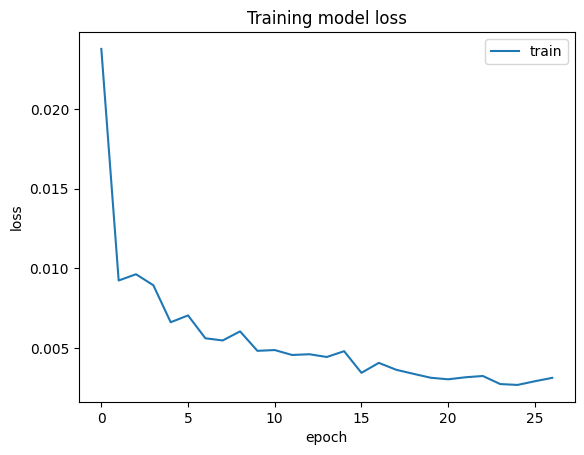

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Training model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc = 'upper right')
plt.show()

**Preparing Test Data for prediction**
* Processes the test data similarly to the training data
* Scales and reshapes test data for prediction

In [ ]:
testData = pd.read_csv('Google_test_data.csv')
testData["Close"] = pd.to_numeric(testData.Close, errors = 'coerce')
testData = testData.dropna()
testData = testData.iloc[:, 4:5]
y_test = testData.iloc[60:, 0:].values
# input array for the model
inputClosing = testData.iloc[:, 0:].values
inputClosing_scaled = sc.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
for i in range(timestep, length):
  X_test.append(inputClosing_scaled[i-timestep:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape

(192, 60, 1)

**Making Predictions**
* Uses the model to predict stock prices
* Inversely transforms the predictions to the original scale

In [ ]:
y_pred = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


In [ ]:
predicted_price = sc.inverse_transform(y_pred)

**Plotting predictions vs Actual Prices**
* Plots actual vs predicted prices

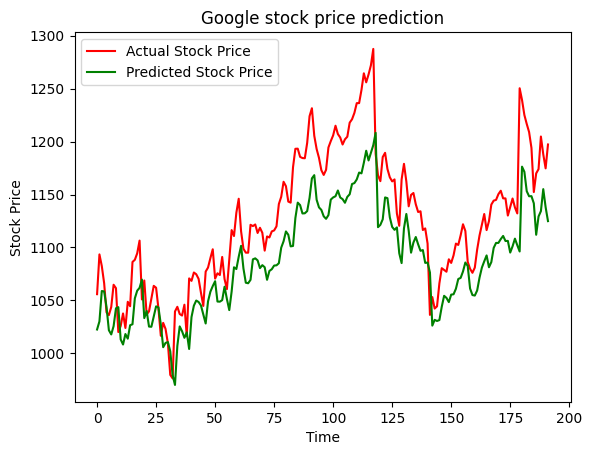

In [ ]:
plt.plot(y_test, color = 'red', label ='Actual Stock Price')
plt.plot(predicted_price, color = 'green', label ='Predicted Stock Price')
plt.title('Google stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

Quantifying quality of prediction:
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* R-squared ($R^2$) score

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, predicted_price)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

# Print the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 4143.436932999374
Root Mean Squared Error (RMSE): 64.36953419902441


In [ ]:
# Calculate R-squared
r2 = r2_score(y_test, predicted_price)

# Print the result
print(f"R-squared (R²) Score: {r2}")

R-squared (R²) Score: 0.004613824636063857


In [ ]:
# Assuming y_test contains the actual test values and y_pred contains the predicted values
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_elements = y_true != 0
    return np.mean(np.abs((y_true[nonzero_elements] - y_pred[nonzero_elements]) / y_true[nonzero_elements])) * 100

# Example usage
# Replace these with your actual test and predicted values
y_test = np.array(testData.iloc[60:, 0])  # Actual values from your test data
y_pred = np.array(predicted_price)         # Predicted values from your model

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f'MAPE: {mape:.2f}%')

MAPE: 6.85%
